IMPORTING THE FUNCTIONS THAT ARE NEEDED

In [2]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

LOAD THE DATA

In [3]:
# Import the data
df = pd.read_csv('/Users/elvisechefu/Desktop/language detection/languages.csv')
df.head()


text language
0  ich denke es handelt sich hier um ein missvers...   german
1                 ich habe tom gerade erst verlassen   german
2                   tom versuchte mary nur zu ärgern   german
3                       tom hat mir die hand geküsst   german
4                    ich wusste dass dir das gefiele   german

In [4]:
# Get all unique languages values
print(df.groupby('language').nunique())
print(f"Total Length of dataset: {len(df)}")


# Check for missing values
print(df.isnull().sum())


# Explore the columns and their types
print(df.info())

            text
language        
english   275687
french    169693
german    199618
spanish   118686
Total Length of dataset: 763684
text        0
language    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763684 entries, 0 to 763683
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      763684 non-null  object
 1   language  763684 non-null  object
dtypes: object(2)
memory usage: 11.7+ MB
None


In [5]:
# Encode language column
# le = preprocessing.LabelEncoder()
# le.fit(df['language'])
# df['language'] = le.transform(df['language'])
# le.classes_

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip (columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df , dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

df = onehot_encode(
    df,
    columns=['language'],
    prefixes=['lan']
)

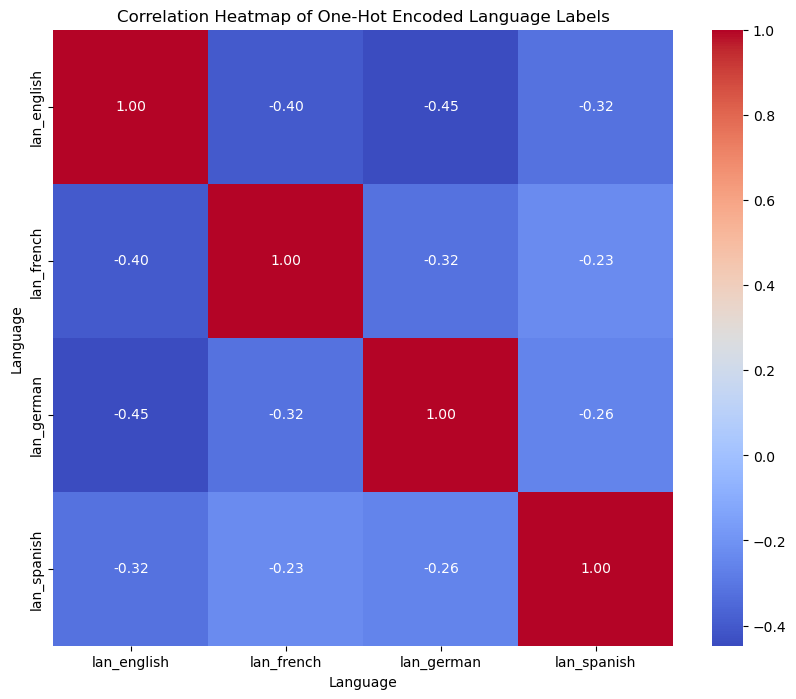

In [6]:
#Represnting the data in a heta-map as a form of visualisation

import seaborn as sns
import matplotlib.pyplot as plt

language_columns = [col for col in df.columns if col.startswith('lan_')]

# Calculate the correlation matrix
correlation_matrix = df[language_columns].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of One-Hot Encoded Language Labels')
plt.xlabel('Language')
plt.ylabel('Language')
plt.show()

In [7]:
y = df.drop('text', axis=1)
X = df['text']
X.head(10)

0    ich denke es handelt sich hier um ein missvers...
1                   ich habe tom gerade erst verlassen
2                     tom versuchte mary nur zu ärgern
3                         tom hat mir die hand geküsst
4                      ich wusste dass dir das gefiele
5                            gehen sie mir aus dem weg
6                           zieht eure schlafanzüge an
7        als kind war ich süchtig nach kriminalromanen
8    ich habe das auto mit zehn prozent rabatt gekauft
9            niemand anders könnte meine arbeit machen
Name: text, dtype: object

In [8]:
y.head()

lan_english  lan_french  lan_german  lan_spanish
0        False       False        True        False
1        False       False        True        False
2        False       False        True        False
3        False       False        True        False
4        False       False        True        False

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y , test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [10]:
# Turn pandas dataframe into TensorFlow Dataset
raw_train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
raw_val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
raw_test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [11]:
# Create batches
batch_size = 65
raw_train_dataset = raw_train_dataset.batch(batch_size)
raw_val_dataset = raw_val_dataset.batch(batch_size)
raw_test_dataset = raw_test_dataset.batch(batch_size)

In [12]:
# Print three labels as example
for text_batch, label_batch in raw_train_dataset.take(1):
    for i in range(3):
       print('Training Review:', text_batch.numpy()[i])
       print("Training Label:", label_batch.numpy()[i])

for text_batch, label_batch in raw_val_dataset.take(1):
    for i in range(3):
       print('Validation Review:', text_batch.numpy()[i])
       print("Validation Label:", label_batch.numpy()[i])

Training Review: b'i got paid much less than i expected'
Training Label: [ True False False False]
Training Review: b'ich glaube tom ist vielleicht weggelaufen'
Training Label: [False False  True False]
Training Review: b'ich m\xc3\xb6chte ski fahren'
Training Label: [False False  True False]
Validation Review: b'black smoke spewed out of the thirdstory windows'
Validation Label: [ True False False False]
Validation Review: b'tom erkannte maria'
Validation Label: [False False  True False]
Validation Review: b'magst du etwas mehr kuchen'
Validation Label: [False False  True False]


In [13]:
# Get number of unique words in entire dataset
from collections import Counter

results = Counter()
df['text'].str.split().apply(results.update)  # Very computer intensive method
len(results)

104611

In [14]:
max_features = 50000  # Total words to vectorize
sequence_length = 20  # The length of a sentence

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Take a smaller sample for adaptation
sample_size = 1000  # Choose an appropriate size based on your dataset size
subset_for_adaptation = df['text'].sample(n=sample_size)

# Adapt to the smaller subset
vectorize_layer.adapt(subset_for_adaptation)

2024-02-29 10:07:26.159365: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [15]:
# Function to vectorize text
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return tf.dtypes.cast(vectorize_layer(text), tf.float32)

In [16]:
# Retrieve a batch from the dataset
text_batch, label_batch = next(iter(raw_test_dataset))
first_review, first_label = text_batch[0], label_batch[0]

print("Review:", first_review)
print("Label:", first_label)
print("Vectorized review:", vectorize_text(first_review))

Review: tf.Tensor(b'the grass is always greener on the other side of the fence', shape=(), dtype=string)
Label: tf.Tensor([ True False False False], shape=(4,), dtype=bool)
Vectorized review: tf.Tensor(
[[  6.   1.  13. 396.   1.  69.   6. 246.   1.  26.   6.   1.   0.   0.
    0.   0.   0.   0.   0.   0.]], shape=(1, 20), dtype=float32)


In [17]:
# Apply the TextVectorization step to the train and test dataset
train_ds = raw_train_dataset.map(lambda x,y: (vectorize_text(x), y))
val_ds = raw_val_dataset.map(lambda x, y: (vectorize_text(x), y))
test_ds = raw_test_dataset.map(lambda x ,y: (vectorize_text(x) , y))

In [18]:
# Performance measures
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
tf.keras.backend.clear_session()

embedding_dim = 32  # Increase the embedding dimension to 32

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim, input_length=20), 
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation=tf.nn.relu), 
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(4, activation=tf.nn.softmax), 
    layers.Dropout(0.5),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            1600032   
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                        

Trainable params: 1,614,724
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [21]:
epochs = 1
history = model.fit(
    train_ds,
    epochs=epochs
)

7050/7050 [==============================] - 36s 5ms/step - loss: nan - accuracy: 0.5131


In [22]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

2350/2350 [==============================] - 1s 383us/step - loss: 0.0482 - accuracy: 0.9813
Validation loss: 0.0481799840927124
Validation accuracy: 0.9813273549079895


In [23]:

# Evaluate model on test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print test results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

2350/2350 [==============================] - 1s 401us/step - loss: 0.0502 - accuracy: 0.9809
Test Loss: 0.050204645842313766
Test Accuracy: 0.980941116809845


In [24]:
print ("Train accuracy:", history.history['accuracy'])
print ("Validation accuracy:", [val_accuracy])
print ("Test accuracy:", [test_accuracy])

Train accuracy: [0.513063907623291]
Validation accuracy: [0.9813273549079895]
Test accuracy: [0.980941116809845]


/Users/elvisechefu/anaconda3/anaconda3/lib/python3.11/site-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/Users/elvisechefu/anaconda3/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


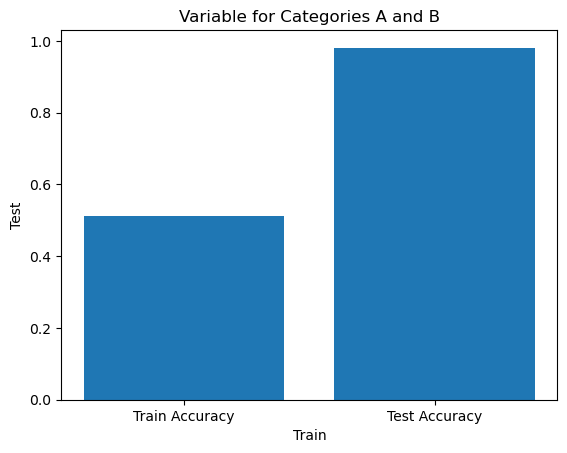

In [25]:
import matplotlib.pyplot as plt

# Data
categories = ['Train Accuracy', 'Test Accuracy']
values = [history.history['accuracy'], test_accuracy]  # Example values for categories A and B

# Plot
plt.bar(categories, values)
plt.xlabel('Train')
plt.ylabel('Test')
plt.title('Variable for Categories A and B')
plt.show()

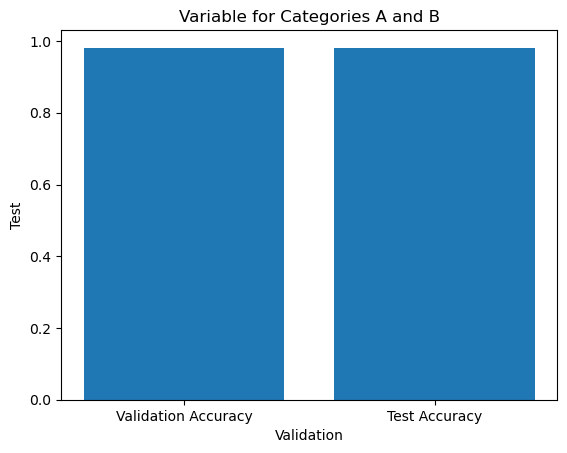

In [26]:
import matplotlib.pyplot as plt

# Data
categories = ['Validation Accuracy', 'Test Accuracy']
values = [val_accuracy, test_accuracy]  # Example values for categories A and B

# Plot
plt.bar(categories, values)
plt.xlabel('Validation')
plt.ylabel('Test')
plt.title('Variable for Categories A and B')
plt.show()

In [27]:
print ("Train loss:", history.history['loss'])
print ("Validation loss:", [val_loss])
print ("Test loss:", [test_loss])

Train loss: [nan]
Validation loss: [0.0481799840927124]
Test loss: [0.050204645842313766]


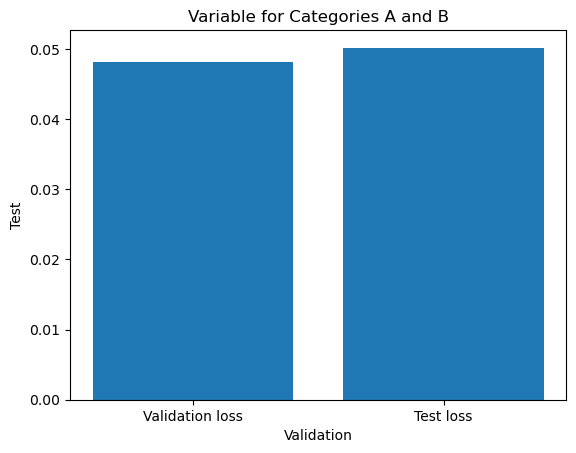

In [28]:
import matplotlib.pyplot as plt

# Data
categories = ['Validation loss', 'Test loss']
values = [val_loss, test_loss]  # Example values for categories A and B

# Plot
plt.bar(categories, values)
plt.xlabel('Validation')
plt.ylabel('Test')
plt.title('Variable for Categories A and B')
plt.show()

In [29]:
#prediction
to_predict = ["Servus was heißt du?"]

to_predict = vectorize_layer(to_predict)
prediction = model.predict(to_predict)

classes = ["English", "French", "German", "Spanish"]

highest_prediction = tf.math.argmax(prediction, 1).numpy()

print(classes[highest_prediction[0]])
print(f"Certainty: {prediction[0][highest_prediction][0] * 100}%")

1/1 [==============================] - 0s 42ms/step
German
Certainty: 96.60395979881287%


In [30]:
#prediction test 2
to_predict = ["Stop that immediate action", "I'm going to the movies tonight"]

to_predict = vectorize_layer(to_predict)
prediction = model.predict(to_predict)

classes = ["English", "French", "German", "Spanish"]

highest_prediction = tf.math.argmax(prediction, 1).numpy()

print(classes[highest_prediction[0]])
print(f"Certainty: {prediction[0][highest_prediction][0] * 100}%")

1/1 [==============================] - 0s 14ms/step
English
Certainty: 99.19637441635132%


In [31]:
to_predict = ["i don't undertand what in the world you're saying"]
prediction = model.predict(vectorize_layer(to_predict))
print(f"Predicted Language: {classes[prediction.argmax()]}, Certainty: {100 * prediction.max():.2f}%")


1/1 [==============================] - 0s 14ms/step
Predicted Language: English, Certainty: 100.00%


In [32]:
to_predict = ["cállate tu boca huele"]
prediction = model.predict(vectorize_layer(to_predict))
print(f"Predicted Language: {classes[prediction.argmax()]}, Certainty: {100 * prediction.max():.2f}%")

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step
Predicted Language: French, Certainty: 78.23%


In [40]:
# Make predictions using the trained model
predictions = model.predict(test_ds)

# Define a threshold for probability
threshold = 0.3  # Adjust as needed

# Check if any predicted probability exceeds the threshold
detected_languages = []
for i, probs in enumerate(predictions):
    for j, prob in enumerate(probs):
        if prob > threshold:
            detected_languages.append(j)  # Language index
            print(f"Detected language {j} with probability {prob}")

# If no additional languages were detected
if not detected_languages:
    print("No additional languages detected.")

2350/2350 [==============================] - 1s 463us/step
Detected language 0 with probability 1.0
Detected language 1 with probability 1.0
Detected language 3 with probability 0.9999984502792358
Detected language 2 with probability 0.9910610318183899
Detected language 2 with probability 0.9999997615814209
Detected language 2 with probability 1.0
Detected language 3 with probability 0.9996452331542969
Detected language 2 with probability 0.9999996423721313
Detected language 2 with probability 1.0
Detected language 2 with probability 0.9998297691345215
Detected language 0 with probability 0.9999998807907104
Detected language 0 with probability 1.0
Detected language 1 with probability 0.9999973773956299
Detected language 2 with probability 0.999988317489624
Detected language 0 with probability 0.99982088804245
Detected language 0 with probability 1.0
Detected language 0 with probability 0.9631973505020142
Detected language 0 with probability 0.9985170960426331
Detected language 2 with p

In [41]:
# Example text to predict
to_predict = ["I love eating croissants and drinking café au lait in Paris."]

# Make predictions for the example text
prediction = model.predict(vectorize_layer(to_predict))

# Define a threshold for probability
threshold = 0.3  # Adjust as needed

# Check if the predicted probability exceeds the threshold
if prediction.max() > threshold:
    # Print the predicted language and certainty
    print(f"Predicted Language: {classes[prediction.argmax()]}, Certainty: {100 * prediction.max():.2f}%")
else:
    print("No language prediction above threshold.")

1/1 [==============================] - 0s 67ms/step
Predicted Language: English, Certainty: 100.00%


In [42]:
# Check if the predicted probability exceeds the threshold
if prediction.max() > threshold:
    # Print the predicted language and certainty
    print(f"Predicted Language: {classes[prediction.argmax()]}, Certainty: {100 * prediction.max():.2f}%")
else:
    print("No language prediction above threshold.")

Predicted Language: English, Certainty: 100.00%
